Based on the [article](https://medium.com/analytics-vidhya/understanding-and-implementing-kalman-filter-in-python-for-pairs-trading-9b8986d79b2d).

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

sns.set(style="whitegrid")

## Preparation

In [2]:
data = pd.read_excel('Data/Data1.xlsx')
data.dropna(axis=1,how='all',inplace=True)
new_cols = []
for i in range(len(data.columns)):
    new_cols.append(data.columns[i] if not data.columns[i].startswith('Unnamed') else new_cols[-1])
data.columns = pd.MultiIndex.from_arrays([new_cols, data.iloc[0]])
data.drop(index=0, inplace=True)
data.head()

Itraxx Main Generic            Itraxx Xover Generic             \
0                 Date Last Price                 Date Last Price   
1  2022-09-22 00:00:00    125.509  2022-09-22 00:00:00     619.11   
2  2022-09-21 00:00:00    122.361  2022-09-21 00:00:00    601.364   
3  2022-09-20 00:00:00    120.426  2022-09-20 00:00:00    596.787   
4  2022-09-16 00:00:00    112.323  2022-09-16 00:00:00    552.824   
5  2022-09-15 00:00:00    108.886  2022-09-15 00:00:00    538.099   

        CDX IG Generic             ER Itraxx Main Long             \
0                 Date Last Price                 Date Last Price   
1  2022-09-22 00:00:00    101.883  2022-09-22 00:00:00   113.3897   
2  2022-09-21 00:00:00    100.584  2022-09-21 00:00:00   113.5834   
3  2022-09-20 00:00:00     98.471  2022-09-20 00:00:00   113.6542   
4  2022-09-19 00:00:00     86.798  2022-09-16 00:00:00   113.7744   
5  2022-09-16 00:00:00      89.17  2022-09-15 00:00:00     113.99   

  ER Itraxx Main Short             ...       ER CDX IG Long             \
0                 Date Last Price  ...                 Date Last Price   
1  2022-09-22 00:00:00    82.9305  ...  2022-09-22 00:00:00        NaN   
2  2022-09-21 00:00:00    82.8257  ...  2022-09-21 00:00:00   110.9141   
3  2022-09-20 00:00:00    82.8096  ...  2022-09-20 00:00:00   111.0292   
4  2022-09-16 00:00:00    82.7576  ...  2022-09-19 00:00:00   111.2009   
5  2022-09-15 00:00:00    82.6014  ...  2022-09-16 00:00:00   111.0792   

       ER CDX IG Short                             SPX                         \
0                 Date Last Price                 Date Last Price      Volume   
1  2022-09-22 00:00:00        NaN  2022-09-22 00:00:00    3778.47           0   
2  2022-09-21 00:00:00    84.9577  2022-09-21 00:00:00    3789.93   650767104   
3  2022-09-20 00:00:00    84.8987  2022-09-20 00:00:00    3855.93   606929216   
4  2022-09-19 00:00:00    84.7962  2022-09-19 00:00:00    3899.89   609422592   
5  2022-09-16 00:00:00    84.8893  2022-09-16 00:00:00    3873.33  2094243200   

                  SX5E                        
0                 Date Last Price     Volume  
1  2022-09-22 00:00:00  3427.1399        NaN  
2  2022-09-21 00:00:00  3491.8701  282749440  
3  2022-09-20 00:00:00  3467.0901  355137088  
4  2022-09-19 00:00:00    3499.49  245934352  
5  2022-09-16 00:00:00  3500.4099  683948800  

[5 rows x 24 columns]

In [28]:
# for multiindex slicing 
idx = pd.IndexSlice

Based on the preselection part from the previous notebook we're going to try trading with the following pair: __ER Itraxx Main Long vs SPX, SX5E__


## Kalman Filter

A little bit of theory:

We assume that the state (spread) we want to modulate follows the equation:

$$
x_t = x_{t-1} + w_t, \mbox{ where } w_t \sim \mathcal{N}(0, Q)
$$

and the measurement equation links the movement of our assets:

$$
z_t = h_t^Tx_t + v_t, \mbox{ where } v_t \sim \mathcal{N}(0, R)
$$

$z_t$ in our case is the value of CDS index and $h_t^T = [\mbox{SPX}, \mbox{SX5E}, 1]$.

From the above we have in our case:

* __State prediction__: $\hat{x}_t = x_{t-1}$

* __Uncertainty of the prediction__: $\hat{P}_t = P_{t-1} + Q$

* __Kalman Gain__: $K_t = \hat{P}_th_t^T(h_t\hat{P}_t h_t^T + R)^{-1}$

* __State update__: $x_t = \hat{x}_t + K_t(z_t-h_t^T\hat{x}_t)$

* __Uncertainty update__: $P_t = (1-K_th_t)\hat{P}_t$

Following the proposition of Chan we also assume:

$$
Q = \frac{\delta}{1-\delta}I, \mbox{ } \delta = 0.0001, \mbox{ and } R=0.001
$$

In [138]:
class KalmanFilter:
    def __init__(self, N=2, delta=1e-4, R=1e-3):
        self.N = N
        self.R = R
        self.Q = delta/(1-delta)*np.eye(N)
        self.x = np.zeros((1, N))
        self.P = np.zeros((N, N))
        self.K = np.zeros((1, N))
    
    def state_pred(self):
        return self.x[-1]
    
    def uncert(self):
        return self.P + self.Q
    
    def kalman_gain(self, h, P):
        if len(h.shape) == 1:
            h = h[None, :]
        K_new = P@h.T/(h@P@h.T+self.R)
        self.K = np.concatenate([self.K, K_new.T], axis=0)
        return K_new
    
    def state_upd(self, z, h):
        if len(h.shape) == 1:
            h = h[None, :]
        x_new = self.x[-1][:, None]+self.K[-1][:, None]@(z-h@self.x[-1][:, None])
        self.x = np.concatenate((self.x, x_new.T), axis=0)
        return x_new
    
    def uncert_upd(self, h, P):
        if len(h.shape) == 1:
            h = h[None, :]
        
        self.P = (np.eye(self.N)-self.K[-1][:, None]@h)@P
        return self.P
    
    def kalman_step(self, z, h):
        x_hat = self.state_pred()
        P_hat = self.uncert()
        K = self.kalman_gain(h, P_hat)
        x = self.state_upd(z, h)
        P = self.uncert_upd(h, P_hat)
        
        return K, x, P, x_hat

In [29]:
tmp = data.loc[:, idx[['SPX', 'SX5E','ER Itraxx Main Long'], :]].dropna(how='any', axis=0)
tmp.reset_index(drop=True, inplace=True)
dates = tmp[idx['SPX', 'Date']]
tmp = tmp.loc[:,idx[:, 'Last Price']]
tmp.columns = [x[0] for x in tmp.columns]
tmp.index = dates
tmp.head()

,SPX,SX5E,ER Itraxx Main Long
"(SPX, Date)",,,
2022-09-21,3789.93,3491.8701,113.5834
2022-09-20,3855.93,3467.0901,113.6542
2022-09-19,3899.89,3499.49,113.7744
2022-09-16,3873.33,3500.4099,113.99
2022-09-15,3901.35,3541.79,114.0442


In [41]:
Z = tmp['ER Itraxx Main Long'].values
H = tmp[['SPX', 'SX5E']].values
H = np.concatenate([H, np.ones(len(H))[:, None]], axis=1)

In [233]:
KF = KalmanFilter(N=3)
for i in range(len(Z)):
    K, x, P, x_hat = KF.kalman_step(Z[i], H[i])

In [235]:
spread = Z-(KF.x[:-1, :-1]*H[:, :-1]).sum(axis=1)

As our spread is too high at t=0 (no prior information about the data), we start from t=1:

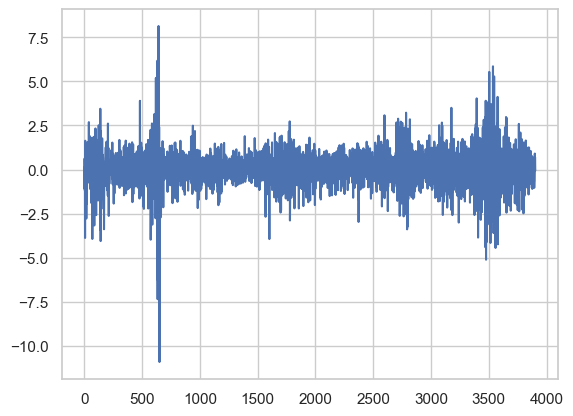

In [237]:
sns.lineplot(spread[1:])
plt.show()

## Trading

Let's try a simple strategy: 

Starting from t=31 (after preceding formation period) we: 

* open a short position when the spread is above 2 std of 30-days mooving average and close that when it hits 1 std
* open a long position when the spread is under -2 std of 30-days mooving average and close that when it hits -1 std


In [334]:
W = 30
signals = np.array([])
p = 0

for i in range(W+1, len(spread)):
    dt = spread[i-W:i]
    s = spread[i]
    ma = np.mean(dt)
    mstd = np.std(dt)
    if s-ma > 2.0*mstd and p != -1:
        p = -1
    elif s-ma < -2.0*mstd and p != 1:
        p = 1
    elif s-ma <= 1.0*mstd and p == -1:
        p = 0
    elif s-ma >= -1.0*mstd and p == 1:
        p = 0
    signals = np.append(signals, p)

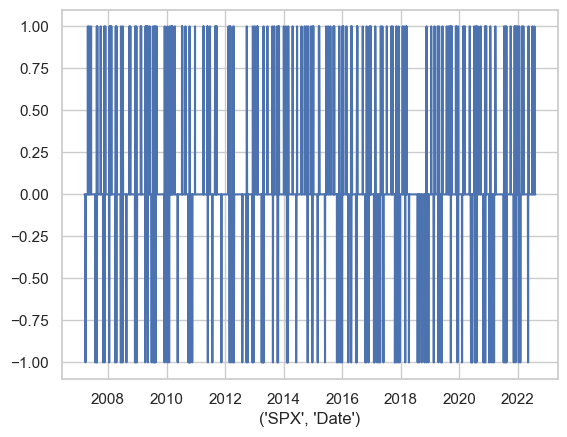

In [335]:
sns.lineplot(x=dates[W+1:][::-1], y=signals)
plt.show()

Starting from t=W+2 our daily gains are computed as change in spread (today vs yesterday) devided by money invested yesterday:

In [336]:
spread_pct_change = Z[W+2:]-Z[W+1:-1]-(KF.x[W+1:-2, :-1]*(H[W+2:, :-1]-H[W+1:-1, :-1])).sum(axis=1)/(Z[W+1:-1]+(KF.x[W+1:-2, :-1]*H[W+1:-1, :-1]).sum(axis=1))
daily_returns = signals[:-1]*spread_pct_change
cumul_returns = (1+daily_returns).cumprod()

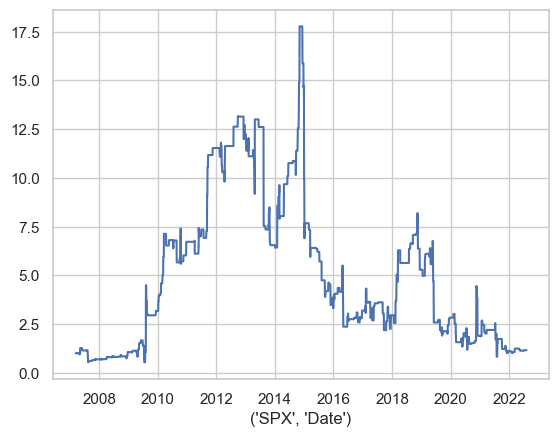

In [337]:
sns.lineplot(y=cumul_returns, x=dates[W+2:][::-1])
plt.show()

Results aren't very promising again but it could be due to:

1) Fundamental non-tradability of these stocks agains each other (that was was said by the owner of the data)

2) Market disruptions 

3) Inaccurate signals generation

Nevertheless, the goal of Kalman Filter implementation is achieved.